# Tutorial - LaserSim

### 0. Before you start

Before starting with this tutorial, read the *how to install LaserSim* guide and follow the instructions. We recommend installing the package into a virtual environment, as it is described in the section there. When you are finished you can try executing the following lines to test if everything works. (Make sure to select the correct kernel.)

In [19]:
import numpy as np
import matplotlib.pyplot as plt 

from LaserSim.crystal import Crystal 
from LaserSim.pump import Pump
from LaserSim.seed import Seed 
from LaserSim.seed_CPA import Seed_CPA 
from LaserSim.amplifier import Amplifier 

### 1. The laser active medium

First, we want to take a look at the laser active material. The class to load a material is called "Crystal". It can be initialized with some starting parameters:
- ```material``` (str): name of the laser material, here you have to specify the name of one of the material subfolders in the material_database 
- ```temperature``` (str): for some materials, the cross sections are available in different temperature ranges
- ```lambda_a```, ```lambda_e``` (float): absorption/emission wavelength in nm, this is just to print the cross section at that wavelength when print(crystal) is executed
- ```length``` (float): specify a length of the crystal, this parameter is normally loaded from the database but can be assigned manually
- ```N_dop``` (float): doping concentration, this parameter is normally loaded from the database but can be assigned manually
- ```smooth_sigmas``` (Bool): Smooth the cross sections by Fourier filtering and a moving average. Additionally, at wavelengths above 1000nm, the absorption is approximated using the emission and the McCumber relation. This is needed, as the absorption is usually very low and noisy.
- resolution (int): manually specify the number of spatial points along the length of the crystal

In [20]:
crystal = Crystal(material = "YbCaF2",
                  temperature = 300,
                  length = None,
                  N_dop = None, 
                  smooth_sigmas=True)

1.01e-06 9.799e-07 1120 1500


We can now gain access to all this information by printing crystal in the console:

In [21]:
print(crystal)

Crystal:
- material = YbCaF2
- length = 11.0 mm
- tau_f = 1.9 ms
- N_dop = 3.3e+20 cm^-3
- sigma_a(940nm) = 1.786e-21cm²
- sigma_e(940nm) = 3.192e-22cm²
- sigma_a(1030nm) = 1.615e-22cm²
- sigma_e(1030nm) = 2.973e-21cm²




#### Plotting

Now we have several functions at our disposal which we can import from the LaserSim.crystal file. One of them is ```plot_cross_sections()``` which will display the cross sections of the laser material. We have the following options when plotting a graph: 

1. ```save``` (bool): Decide, whether or not the plot should be saved. The standard folder for this is "material_database/plots". 
2. ```save_path``` (str): The path + name of the file can be specified manually.

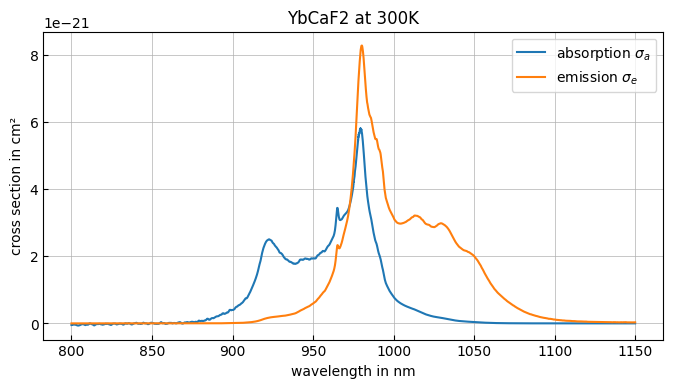

In [22]:
from LaserSim.crystal import plot_cross_sections
plot_cross_sections(crystal, save=False, save_path=None)

Furthermore, we can plot the small signal gain of the laser material for a given inversion $\beta$. For that we import the function *plot_small_signal_gain*. The inversion $\beta$ can either be specified as a float or inside an array of several inversions, which are then displayed in a single plot.

There are a few more functions to plot other parameters of the laser medium:
- ```plot_beta_eq()``` - plot the equilibrium inversion with a logistic fit function 
- ```plot_Isat()``` - plot the saturation intensity
- ```plot_Fsat()``` - plot the saturation fluence

d:\Martin\GitHub\Laser_Simulation\material_database\plots\YbCaF2_300K_small_signal_gain.pdf


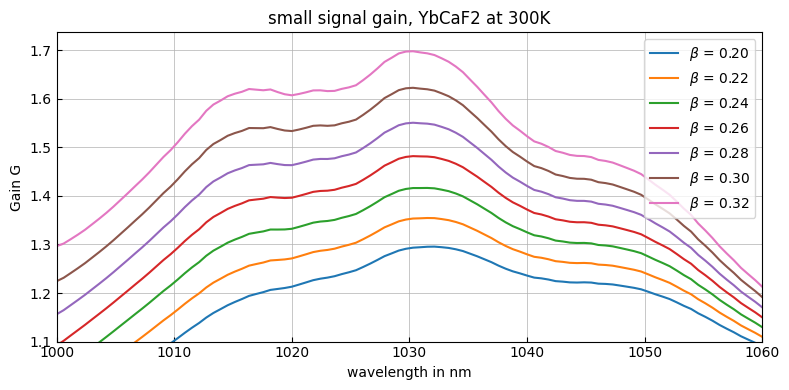

In [23]:
from LaserSim.crystal import plot_small_signal_gain

beta = [0.2,0.22,0.24,0.26,0.28,0.3,0.32]
plot_small_signal_gain(crystal, beta, save=True)

### 2. The laser seed pulse

Next, we want to consider the laser seed pulse. There exist two different kinds of seed pulses - a temporal and a spectral pulse. With the first we can simulate the change in the temporal profile during the amplification, whereas with the second we can analyze the change in the spectrum of a given wavelength distribution during amplification.

Again, we can simply load two instances of those classes and set their (standard) properties:

In [ ]:
seed = Seed(fluence = 0.01,             # input fluence in J/cm²
            duration = 5,               # pulse duration in ns
            wavelength = 1030,          # monochromatic wavelength of the pulse
            gauss_order = 1,            # Gaussian order if seed_type = "gauss" is chosen
            seed_type = "gauss")        # seed shape type: "gauss", "rect" or "lorentz"

seed_CPA = Seed_CPA(wavelength = 1030,  # central wavelength of the pulse
            bandwidth = 30,             # bandwidth of the pulse
            fluence =  1e-4,            # input fluence in J/cm²
            gauss_order = 1,            # Gaussian order if seed_type = "gauss" is chosen
            seed_type = "gauss",        # seed shape type: "gauss", "rect" or "lorentz"
            custom_file = None)         # custom file for seed pulse

As before, we can do plots to show the temporal and spectral profile of a given laser seed pulse.

In [ ]:
from LaserSim.seed import plot_seed_pulse
from LaserSim.seed_CPA import plot_seed_pulse as plot_seed_CPA_pulse

plot_seed_pulse(seed, save=False)
plot_seed_CPA_pulse(seed_CPA, save=False)

### 3. The amplifier

Finally, we want to simulate a whole amplifier. For now we concentrate on the simulation of the temporal pulse profile. First we need to pump the medium using a CW pump pulse. This is initialized with an instance of the ```Pump``` class. Then we initialize the amplifier by calling the ```Amplifier``` class and printing it to see all the details. Note that we already initialized the crystal and seed in the previous sections. We can also call the print() method to display all important information.

In [ ]:
pump = Pump(intensity = 30,                 # input intensity in kW/cm²
            duration = 2,                   # pulse duration in ns
            wavelength = 940,               # monochromatic wavelength (in nm) of the quasi-CW pulse
            ) 

amplifier = Amplifier(crystal, pump, seed, 
                      passes = 50,          # number of passes through the medium
                      losses = 0.02,        # losses in the cavity
                      max_fluence = 10)     # maximum output fluence allowed in the cavity in J/cm²

print(amplifier)

Now, we start our calculations by pumping the crystal. This is done using the ```inversion()``` method of amplifier. We can display the spatial distribution of the inversion using ```plot_inversion1D()```.

- The ```inversion()``` method returns a 1D array containing the spatial inversion at the last time step.

In [ ]:
from LaserSim.amplifier import plot_inversion1D

beta = amplifier.inversion()   # is also called by plot_inversion1D, if not called before

plot_inversion1D(amplifier, save=False)

We can now continue to extract energy using the seed pulse. For this we call the *extraction()* method of the amplifier. Then we can make two different plots:

- ```plot_total_fluence_per_pass()```: shows the total fluence of the pulse for every pass
- ```plot_temporal_fluence()```: shows the temporal evolution of the pulse shape for the last ten pases

In [ ]:
from LaserSim.amplifier import plot_total_fluence_per_pass, plot_temporal_fluence
# this line is not needed, as the extraction method is calculated in the plot function  aswell.
total_fluence, temporal_fluence = amplifier.extraction()

plot_total_fluence_per_pass(amplifier)
plot_temporal_fluence(amplifier)